## Constant folding is too slow here
1. fft operate a global variable
2. The second run is fast
3. solution: pass the global variable as a arg

In [7]:
import time
import jax
import numpy as np
import jax.numpy as jnp

key = jax.random.PRNGKey(0)

def f():
    pulse = jax.device_put(np.arange(8000)+1.0j)
    #pulse = jax.random.normal(key, (8000,))
    return jnp.fft.fft(pulse)

t0 = time.time()
a = jax.jit(f, backend='gpu')()
t1 = time.time()
print('time cost on gpu:',t1-t0)


t0 = time.time()
a = jax.jit(f, backend='cpu')()
t1 = time.time()
print('time cost on cpu:',t1-t0)

time cost on gpu: 7.2172324657440186
time cost on cpu: 0.03505373001098633


In [4]:
t0 = time.time()
a = jax.jit(f, backend='gpu')()
t1 = time.time()
print('time cost on gpu:',t1-t0)


t0 = time.time()
a = jax.jit(f, backend='cpu')()
t1 = time.time()
print('time cost on cpu:',t1-t0)

time cost on gpu: 0.00124359130859375
time cost on cpu: 0.0014529228210449219


In [10]:
@jax.jit
def f(x):
  large_constant = jax.device_put(np.random.rand(8000))
  def g(y):
     return jnp.fft.fft(large_constant) + y # okay
  return g(x)

t0 = time.time()
f(1)
t1 = time.time()
print('time cost on gpu:',t1-t0)

time cost on gpu: 6.859097957611084


In [5]:
import time
import jax
import numpy as np
import jax.numpy as jnp

pulse = jax.device_put(np.random.rand(1000000))

def f(pulse):
    return jnp.fft.fft(pulse)

t0 = time.time()
a = jax.jit(f, backend='gpu')(pulse)
t1 = time.time()
print('time cost on gpu:',t1-t0)


t0 = time.time()
a = jax.jit(f, backend='cpu')(pulse)
t1 = time.time()
print('time cost on cpu:',t1-t0)

time cost on gpu: 0.9139416217803955
time cost on cpu: 0.15781903266906738


# WDM system

## Transmitter
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import device_put, device_get
import jax.random as random
from commplax.module import core

import optical_flax.base as base
from optical_flax.models import manakov_ssf, cssfm
from optical_flax.tx import simpleWDMTx
from optical_flax.core import parameters
from optical_flax.dsp import simple_dsp, mimo_dsp
from collections import namedtuple
import pickle

from gdbp import gdbp_base as gb, data as gdat, aux
import optax
from optical_flax.utils import auto_rho
Input = namedtuple('DataInput', ['y', 'x', 'w0', 'a'])

## 测试进度条
from tqdm import tqdm
from time import sleep
for i in tqdm(range(20)):
        sleep(.01)

100%|██████████| 20/20 [00:00<00:00, 98.39it/s]


In [9]:
## Transmitter
from optical_flax.tx import QAM
from functools import partial
from optical_flax.dsp import pulseShape
param = parameters()
param.M   = 16           # modulation formate
param.Rs  = 36e9         # symbol rate [baud]
param.SpS = 16            # samples/symb
param.Nbits = 400000      # number of bits
param.pulse_type = 'rc'   # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.1    # rolloff do filtro RRC
param.Pch_dBm = 0        # potência média por canal WDM [dBm]
param.Nch     = 11       # número de canais WDM
param.Fc      = 299792458/1550E-9 # frequência central do espectro WDM
param.freqSpac = 50e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 2         # número de modos de polarização
param.mod = QAM(M=param.M)  # modulation
param.equation = 'NLSE'

# pulse shaping
Ts  = 1/param.Rs        # symbol period [s]
if param.pulse_type == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse_type == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=Ts)
elif param.pulse_type == 'rc':
    pulse = pulseShape('rc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=Ts)
pulse = jax.device_put(pulse/np.max(np.abs(pulse)))
param.pulse = pulse

# central frequencies of the WDM channels
freqGrid = np.arange(-int(param.Nch/2), int(param.Nch/2)+1,1)*param.freqSpac
if (param.Nch % 2) == 0:
    freqGrid += param.freqSpac/2

if param.equation == 'NLSE':
    param.freqGrid = freqGrid
else:
    param.freqGrid = freqGrid*0

# import pickle
# path = 'sml_data/Tx_ch7_N4e6'
# with open(path,'wb') as file:
#     pickle.dump((sigWDM_Tx, symbTx_, param), file)
# print('data is saved!')

In [10]:
key = jax.random.PRNGKey(123)
batch = 10
key_full = jax.random.split(key, batch)
signal = []
symbol = []
for i in range(batch):
    sigWDM_Tx, symbTx_ = simpleWDMTx(key_full[i], pulse, param)
    signal.append(sigWDM_Tx)
    symbol.append(symbTx_)

sigWDM = jnp.stack(signal, 0)
symbWDM = jnp.stack(symbol, 0)
print(f'signal shape: {sigWDM.shape}, symb shape: {symbWDM.shape}')


Sample rate fa: 5.76e+11, Cut off frequency fc: 2.75e+11, fa > 2fc: True
signal shape: (10, 1600000, 2), symb shape: (10, 100000, 11, 2)


Text(0.5, 1.0, 'optical WDM spectrum')

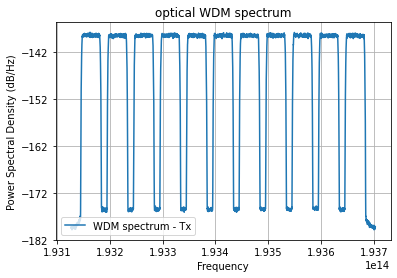

In [11]:
# plot psd
plt.figure()
plt.psd(sigWDM[0,:,0], Fs=param.SpS*param.Rs, Fc=param.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum')

## channel
---

In [12]:
np.random.seed(2333)
linearChannel = False
paramCh = parameters()
paramCh.Ltotal = 1125   # km
paramCh.Lspan  = 75     # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16.5       # ps/nm/km
paramCh.Fc = 299792458/1550E-9 # Hz
paramCh.hz =  1      # km
paramCh.gamma = 1.3174420805376552    # 1/(W.km)
paramCh.amp = 'edfa'
paramCh.NF = 4.5
if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)
Fs = param.Rs*param.SpS  # sample rates
from optical_flax.models import ssfm, manakov_ssf

In [13]:
sigWDM_ = jax.vmap(manakov_ssf,in_axes=(0,None,None), out_axes=0)(sigWDM, Fs, paramCh) 
print(sigWDM_.shape)

(10, 1600000, 2)


## Rx

In [14]:
### Receiver
from optical_flax.rx import simpleRx, sml_dataset
np.random.seed(123)
paramRx = parameters()
paramRx.chid = int(param.Nch / 2) 
paramRx.sps = 2
paramRx.lw = 100e3       # linewidth
paramRx.Rs = param.Rs
FO = 64e6           # frequency offset
paramRx.FO = FO

paramRx.tx_sps = param.SpS
paramRx.pulse = param.pulse
paramRx.Ta = 1/(param.SpS*param.Rs)


key_rx = jax.random.PRNGKey(233)
key_rx_full = jax.random.split(key_rx, batch)
sigRx = jax.vmap(simpleRx, in_axes=(0,None,None,0,None),out_axes=0)(key_rx_full, FO, param.freqGrid[paramRx.chid], sigWDM_, paramRx)

In [15]:
print(sigRx.shape)

(10, 200000, 2)


In [ ]:
import pickle
path = 'sml_data/Tx_ch7_N4e6'

with open(path,'rb') as file:
    sigWDM_Tx, symbTx_, param = pickle.load(file)

print(f'signal shape: {sigWDM_Tx.shape}, symb shape: {symbTx_.shape}')

signal shape: (16000000, 2), symb shape: (1000000, 2, 7)


100%|██████████| 15/15 [15:16<00:00, 61.13s/it]


Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 64.00 MHz

data has been saved!


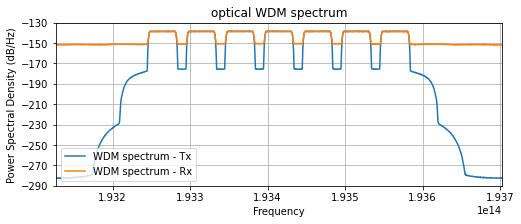

In [ ]:
## optical fiber
np.random.seed(2333)
linearChannel = False
paramCh = parameters()
paramCh.Ltotal = 1125   # km
paramCh.Lspan  = 75     # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16.5       # ps/nm/km
paramCh.Fc = 299792458/1550E-9 # Hz
paramCh.hz =  15      # km
paramCh.gamma = 1.3174420805376552    # 1/(W.km)
paramCh.amp = 'edfa'
if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)
Fs = param.Rs*param.SpS  # sample rates
# sigWDM_, paramCh = ssfm(sigWDM_Tx, Fs, paramCh) 
sigWDM, paramCh = manakov_ssf(sigWDM_Tx, Fs, paramCh) 

# plot psd of tx and rx
plt.figure(figsize=(8,3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2)
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum')


### Receiver
from optical_flax.rx import simpleRx, sml_dataset
np.random.seed(123)
paramRx = parameters()
paramRx.chid = int(param.Nch / 2)
paramRx.sps = 2
paramRx.lw = 100e3       # linewidth
paramRx.Rs = param.Rs
FO = 64e6           # frequency offset

paramRx.tx_sps = param.SpS
paramRx.pulse = param.pulse
paramRx.freq = param.freqGrid[paramRx.chid]
paramRx.Ta = 1/(param.SpS*param.Rs)

sigRx, paramRx = simpleRx(sigWDM, paramRx)
data_sml = sml_dataset(sigRx, symbTx_, param, paramCh, paramRx, save=True, path='sml_data/dataset_ch7_N4e6_dz15')
